# Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import MiniBatchNMF

In [2]:
ratings = pd.read_csv("../data/movielens/ratings.csv")

# Preprocessing

In [3]:
ratings = ratings.drop(columns="timestamp")
ratings.head(2)

,user_id,movie_id,rating
0,1,1,4.0
1,1,110,4.0


In [4]:
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_ratings = ratings["rating"].shape[0]

print(f"There are {n_users} users in the dataset.")
print(f"There are {n_movies} movies in the dataset.")
print(f"There are {n_ratings} ratings in the dataset.")

There are 330975 users in the dataset.
There are 83239 movies in the dataset.
There are 33832162 ratings in the dataset.


## Filtering

In [ ]:
# Finding stats on user ratings
ratings_per_user = ratings.groupby("user_id").size()
print(f"Average ratings per user: {ratings_per_user.mean():.2f}")
print(f"Median ratings per user: {ratings_per_user.median():.2f}")
print(f"Min ratings: {ratings_per_user.min()}")
print(f"Max ratings: {ratings_per_user.max()}")
print()
mean_user_rating = ratings_per_user.mean()

# Filtering out users with less than the average number of ratings
user_rating_counts = ratings["user_id"].value_counts()
average_users = user_rating_counts[user_rating_counts >= mean_user_rating].index
filtered_ratings = ratings[ratings["user_id"].isin(average_users)]

# Reviewing the filtered dataset
n_users_filtered = filtered_ratings["user_id"].nunique()
print(f"There are now {n_users_filtered} users in the dataset. {n_users_filtered / n_users:.2%} of the original dataset.")

Average ratings per user: 102.22
Median ratings per user: 31.00
Min ratings: 1
Max ratings: 33332

There are now 17292 users in the dataset. 5.22% of the original dataset.


In [ ]:
# Finding stats on movie ratings
ratings_per_movie = ratings.groupby("movie_id").size()
print(f"Average ratings per movie: {ratings_per_movie.mean():.2f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.2f}")
print(f"Min ratings: {ratings_per_movie.min()}")
print(f"Max ratings: {ratings_per_movie.max()}")
print()

# Filtering out movies with few ratings
movie_rating_counts = filtered_ratings["movie_id"].value_counts()
average_movies = movie_rating_counts[movie_rating_counts >= 25].index
filtered_ratings = filtered_ratings[filtered_ratings["movie_id"].isin(average_movies)]

# Reviewing the filtered dataset
n_movies_filtered = filtered_ratings["movie_id"].nunique()
print(f"There are now {n_movies_filtered} movies in the dataset. {n_movies_filtered / n_movies:.2%} of the original dataset.")

Average ratings per movie: 406.45
Median ratings per movie: 5.00
Min ratings: 1
Max ratings: 122296

There are now 11002 movies in the dataset. 13.22% of the original dataset.


In [7]:
# Reviewing the number of ratings
n_ratings_filtered = filtered_ratings["rating"].shape[0]
print(f"There are now {n_ratings_filtered} ratings in the dataset. {n_ratings_filtered / n_ratings:.2%} of the original dataset.")

There are now 13369702 ratings in the dataset. 39.52% of the original dataset.


In [8]:
ratings = filtered_ratings

## Scaling user ratings

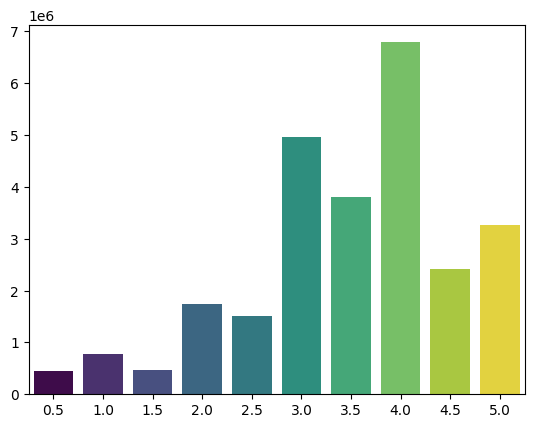

In [10]:
# Visualising the rating distribution
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()), hue=list(rating_distribution.keys()), palette="viridis", legend=False);

In [9]:
def scaler(df):
    """
    Scales (standardising and normalising) the ratings of each user. 
    Standardising is necessary since the ratings overall are not normally distributed 
    and some users might always rate high, low or with a large variance. 
    Normalising is necessary since matrix factorisation can only handle non-negative values.

    Arguments:
    df -- DataFrame with user_id, movie_id and rating columns

    Returns:
    df -- DataFrame with user_id, movie_id and scaled rating columns
    """
    df_collection = []
    for user, user_df in df.groupby("user_id"): 
        rating_values = user_df["rating"].values
        mean = np.mean(rating_values)
        std = np.std(rating_values)
        if std < 1e-10:
            user_df["rating"]=0.5 # if std is 0, set rating to 0.5 which is an average rating once ratings are normalised (0 to 1)
        else:
            std_values = (rating_values - mean) / std
            min_std = np.min(std_values)
            max_std = np.max(std_values)
            user_df["rating"] = (std_values - min_std) / (max_std - min_std)
        df_collection.append(user_df) # stores dataframes in a list which are concatenated at the end
    return pd.concat(df_collection)


scaled_ratings = ratings.copy()
scaled_ratings = scaler(scaled_ratings)

In [10]:
scaled_ratings.head(2)

,user_id,movie_id,rating
1538,22,16,0.666667
1539,22,18,1.000000


In [11]:
ratings = scaled_ratings

## User-movie matrix

### Approach A

In [ ]:
# Creating a user-movie matrix using pivot_table() crashes the kernel. 
# I tried creating a sparse matrix (see line below) with user_id, movie_id and rating as rows, columns and values but that resulted in a much larger matrix than users*movies. 
# sparse_matrix = coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))
# From my understanding the issue is that the IDs are not contiguous (0, 1, 2, 3 ...) resulting in a shape of max_user_ID*max_movie_ID.
# I asked Claude Sonnet 3.7 to: "Modify the code to create a sparse matrix in the shape of users*movies."

# Get unique user and movie IDs
unique_users = np.sort(ratings["user_id"].unique())
unique_movies = np.sort(ratings["movie_id"].unique())

# Create mappings from original IDs to consecutive indices
user_mapper = {user: i for i, user in enumerate(unique_users)}
movie_mapper = {movie: i for i, movie in enumerate(unique_movies)}

# Map original IDs to indices
rows = np.array([user_mapper[user] for user in ratings["user_id"]])
cols = np.array([movie_mapper[movie] for movie in ratings["movie_id"]])
vals = ratings["rating"].values

# Create the sparse matrix with appropriate shape
rating_matrix = csr_matrix((vals, (rows, cols)), shape=(len(unique_users), len(unique_movies)))

I believe the original IDs are lost in the above method. 

In [25]:
density = rating_matrix.nnz / (rating_matrix.shape[0] * rating_matrix.shape[1])
print(f"Only {density * 100:.3f} % of the matrix contains ratings.") 

Only 1.547 % of the matrix contains ratings.


In [31]:
rating_matrix.shape

(79469, 21297)

In [29]:
sparse_df = pd.DataFrame.sparse.from_spmatrix(
    sparse_matrix,
    index=unique_users,
    columns=unique_movies
)

In [30]:
sparse_df.head(2)

,1,2,3,4,5,6,7,8,9,10,...,287377,287591,287609,287633,287731,288167,288265,288269,288311,288679
7,0.666667,0,0.333333,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0.75,1.0,0,0.5,0.75,0,0,0,0.75,...,0,0,0,0,0,0,0,0,0,0


# Matrix factorisation

In [40]:
n = 20
b = 5000
aW = 0.1
aH = 0.1

nmf = MiniBatchNMF(n_components=n, batch_size=b, alpha_W=aW, alpha_H=aH, max_iter=m)
W = nmf.fit_transform(rating_matrix)
H = nmf.components_
print(f"Shape of W: {W.shape}")
print(f"Shape of H: {H.shape}")

Shape of W: (79469, 20)
Shape of H: (20, 21297)


In [ ]:
def get_movie_recommendations(input_movie_title, movies_df, n_recommendations=5):
    movie_row = movies_df[movies_df["title"].str.contains(input_movie_title, case=False)]
    if movie_row.empty:
        return "Movie not found"
    movie_id = movie_row.iloc[0]["movie_id"]
    if movie_id not in movie_mapper:
        return "Movie not in rating dataset"
    movie_idx = movie_mapper[movie_id]
    movie_factors = H[:, movie_idx]
    similarity_scores = np.dot(movie_factors, H)
    inverse_movie_mapper = {idx: mid for mid, idx in movie_mapper.items()}
    recommendations = pd.DataFrame({
        "movie_id": [inverse_movie_mapper[i] for i in range(len(similarity_scores))],
        "similarity": similarity_scores
    })
    recommendations = recommendations[recommendations["movie_id"] != movie_id]
    top_recs = recommendations.sort_values("similarity", ascending=False).head(n_recommendations)
    return top_recs.merge(movies_df, on="movie_id")[["title", "similarity"]]

In [13]:
movies = pd.read_csv("../data/movielens/movies.csv")
movies["genres"] = movies["genres"].replace("(no genres listed)", np.nan)
movies["genres"] = movies["genres"].str.lower().str.replace("|", " ").str.replace("-", "").str.strip()
movies["year"] = movies["title"].str.extract(r"\((\d{4})\)")
movies["title"] = movies["title"].str.replace(r"\[.*?\]|\(.*?\)", "", regex=True).str.strip()
movies.dropna(how="any", inplace=True) # dropping 7300 NaN values
movies = movies.drop(columns="genres")

In [14]:
movies.shape

(79237, 3)

In [15]:
movies = movies[movies["movie_id"].isin(ratings["movie_id"].unique())]

In [16]:
movies.shape

(10941, 3)

In [52]:
temp = get_movie_recommendations("Toy Story", movies, n_recommendations=5)
print(temp)

                                title  similarity
0           Shawshank Redemption, The    0.004631
1                         Matrix, The    0.004607
2                        Pulp Fiction    0.004491
3                        Forrest Gump    0.004359
4  Star Wars: Episode IV - A New Hope    0.004307


These movies seem to be generally solid movies but not solid recommendations. So generally popular movies rather than related to Toy Story. 